In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import pandas as pd

from torchsummary import summary
from torchvision import transforms

from data import data_transforms

# Analyse training

In [120]:
df = pd.read_csv('experiment/train_loss_tab.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'experiment/train_loss_tab.csv'

In [83]:
best_epoch = df['val_loss'].argmin()+1
floor_best_epoch = 10 * (best_epoch//10)
ceil_best_epoch = 10 * (best_epoch//10 + 1)
print(f"{best_epoch = }, {floor_best_epoch = }")

best_epoch = 13, floor_best_epoch = 10


In [84]:
print(df['val_loss'][best_epoch-1])
print(df['val_loss'][floor_best_epoch-1])
print(df['val_loss'][ceil_best_epoch-1])
print(df['val_acc'][best_epoch-1])
print(df['val_acc'][floor_best_epoch-1])
print(df['val_acc'][ceil_best_epoch-1])

0.0157322796803076
0.0162582987720526
0.0183112262522132
70.87378692626953
70.87378692626953
68.93203735351562


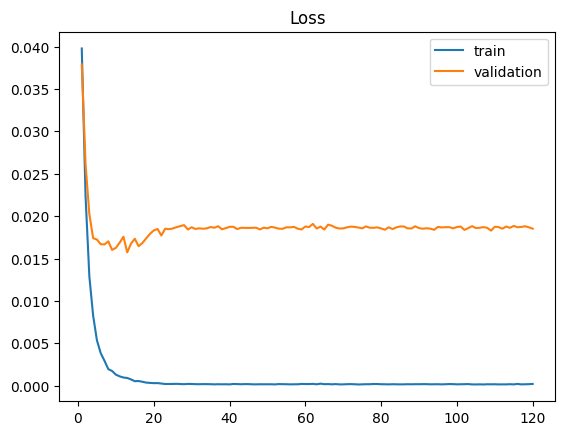

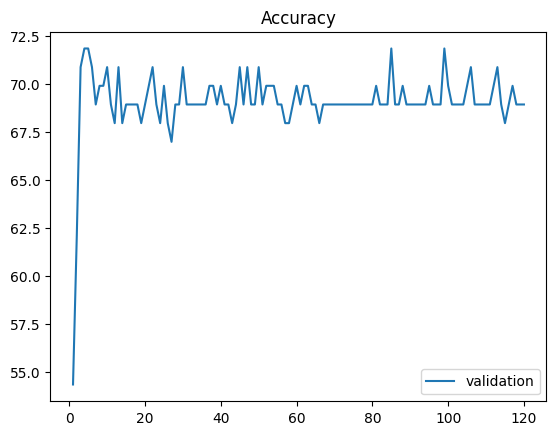

In [85]:
if True:
    plt.plot(df['epoch'],df['train_loss'],label='train')
    plt.plot(df['epoch'],df['val_loss'],label='validation')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(df['epoch'],df['val_acc'],label='validation')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

# Test

In [3]:
nclasses = 20
class EndModel(nn.Module):

    def __init__(self,in_features,out_features):
        super(EndModel,self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        #self.fc2 = nn.Linear(256, out_features)

        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return x
        #return self.fc2(x)


class Net(nn.Module):

    def __init__(self,nclasses):
        super(Net,self).__init__()

        self.resnet = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
        self.num_ftrs = self.resnet.fc.out_features
        self.endmodel = EndModel(self.num_ftrs,nclasses)

        # freeze the resnet layers
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self,x):
        x = self.resnet(x)
        return x

In [4]:
model = Net(20).to("cuda")

In [73]:
def center_crop_main_axis(image):
    """Center crop the image on the smallest axis. Basicaly extract the center square."""
    if image.shape[-1] > image.shape[-2]:
        res = transforms.CenterCrop((image.shape[-2], image.shape[-2]))(image)
    else:
        res = transforms.CenterCrop((image.shape[-1], image.shape[-1]))(image)
    return res

In [79]:
class CenterCropMainAxis:

    def __init__(self) -> None:
        pass

    def __call__(self, image):
        return center_crop_main_axis(image)

In [116]:
data_transforms = transforms.Compose([
    # data augmentation
    transforms.RandomRotation(30),
    transforms.GaussianBlur(3, sigma=(0.01, 2.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    # properly crop the data to avoid stretching
    CenterCropMainAxis(),
    # Res net transforms
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])


In [117]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/train_images',
                         transform=data_transforms),
    batch_size=64, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/val_images',
                         transform=data_transforms),
    batch_size=64, shuffle=False, num_workers=0)


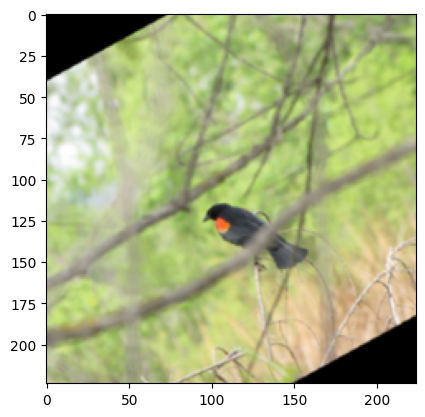

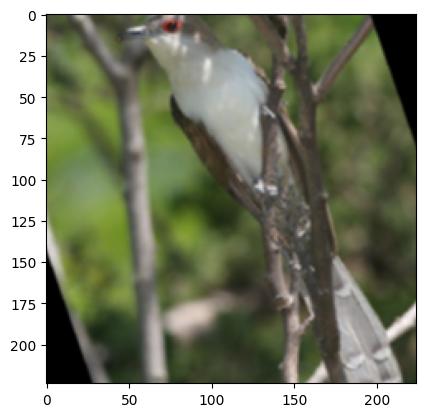

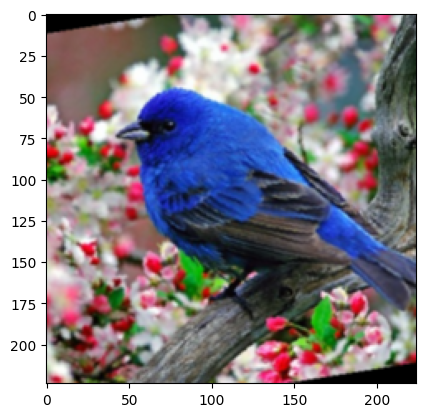

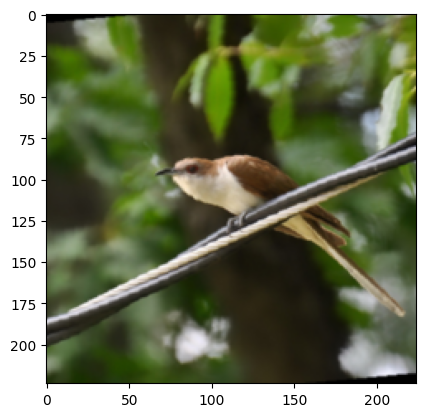

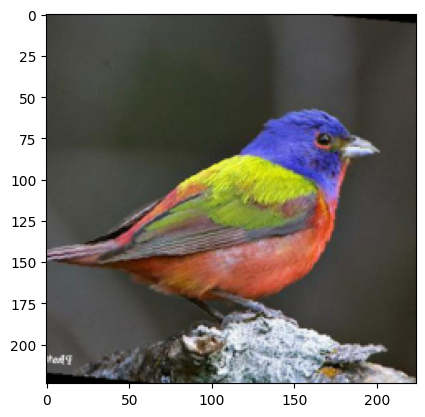

In [119]:
for idx in np.random.randint(len(train_loader.dataset), size=5):
    img, label = train_loader.dataset[idx]
    img = np.moveaxis(img.numpy(),0,2)
    plt.imshow(img)
    plt.show()


In [57]:
img_t = transforms.ToTensor()(img)
img_t.shape[-2]

498

torch.Size([3, 420, 420])


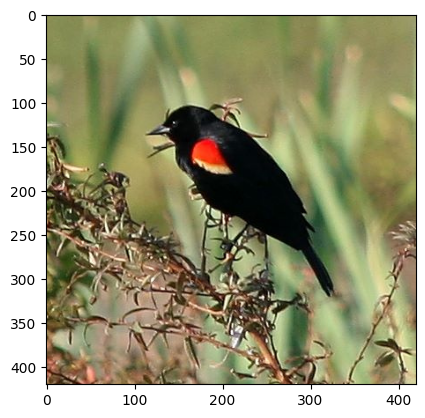

In [59]:
img_cropped = center_crop_main_axis(img_t)
print(img_cropped.shape)
plt.imshow(np.moveaxis(img_cropped.numpy(),0,2))

In [40]:
def resize_main_axis(image):
    """Resize the image to a square with the same main axis length."""
    if image.size[0] > image.size[1]:
        image = torchvision.transforms.Resize((image.size[0], image.size[0]))(image)
    else:
        image = torchvision.transforms.Resize((image.size[1], image.size[1]))(image)
    return image

class ResizeMainAxis:

    def __init__(self) -> None:
        

torch.Size([3, 498, 420])